In [29]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer,TFAutoModel
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
emotion_dataset=load_dataset("emotion")
emotion_dataset.set_format(type="pandas")
df_train=emotion_dataset["train"][:]

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/prajw/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.24it/s]


In [3]:
df_train

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [4]:
def label_int2str(row):
    return emotion_dataset["train"].features['label'].int2str(row)

df_train["label_name"]=df_train["label"].apply(label_int2str)

In [5]:
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


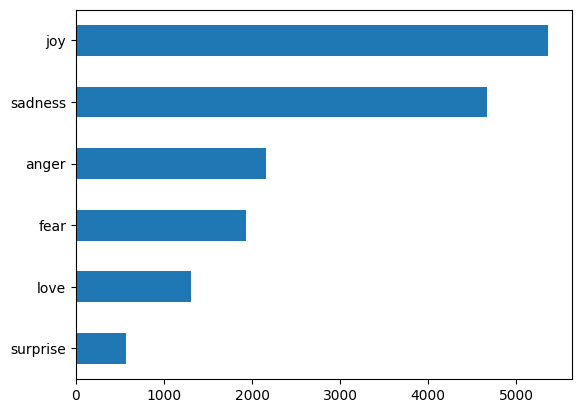

In [6]:
df_train["label_name"].value_counts(ascending=True).plot.barh()
plt.show()

In [7]:
emotion_dataset.reset_format()

In [8]:
model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

emotion_dataset_encode=emotion_dataset.map(tokenize,batched=True,batch_size=None)

Loading cached processed dataset at C:\Users\prajw\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-4d924eeeec90cd77.arrow
Loading cached processed dataset at C:\Users\prajw\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-367f8aa48e7b479e.arrow
Loading cached processed dataset at C:\Users\prajw\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-49f8a4484df2386c.arrow


In [9]:
emotion_dataset_encode

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [10]:
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [11]:
emotion_dataset_encode.reset_format()

In [13]:
def extract_hidden_states(batch):
    inputs=tokenizer(batch['text'],
                     padding=True,
                    truncation=True,
                    return_tensors="tf")
    outputs=tf_model(inputs)
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

emotion_dataset_hidden=emotion_dataset_encode.map(extract_hidden_states,batched=True)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...distilbert
......vars
...distilbert\embeddings
......vars
.........0
.........1
...distilbert\embeddings\LayerNorm
......vars
.........0
.........1
...distilbert\embeddings\dropout
......vars
...distilbert\transformer
......vars
...distilbert\transformer\layer\tf_transformer_block
......vars
...distilbert\transformer\layer\tf_transformer_block\attention
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\dropout
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\k_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\out_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\q_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\v_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\dropout
......vars


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [10:28<00:00, 39.27s/ba]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...distilbert
......vars
...distilbert\embeddings
......vars
.........0
.........1
...distilbert\embeddings\LayerNorm
......vars
.........0
.........1
...distilbert\embeddings\dropout
......vars
...distilbert\transformer
......vars
...distilbert\transformer\layer\tf_transformer_block
......vars
...distilbert\transformer\layer\tf_transformer_block\attention
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\dropout
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\k_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\out_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\q_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\v_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\dropout
......vars


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:23<00:00, 41.86s/ba]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...distilbert
......vars
...distilbert\embeddings
......vars
.........0
.........1
...distilbert\embeddings\LayerNorm
......vars
.........0
.........1
...distilbert\embeddings\dropout
......vars
...distilbert\transformer
......vars
...distilbert\transformer\layer\tf_transformer_block
......vars
...distilbert\transformer\layer\tf_transformer_block\attention
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\dropout
......vars
...distilbert\transformer\layer\tf_transformer_block\attention\k_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\out_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\q_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\attention\v_lin
......vars
.........0
.........1
...distilbert\transformer\layer\tf_transformer_block\dropout
......vars


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:24<00:00, 42.09s/ba]


In [26]:
emotion_dataset_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [24]:
X_train=np.array(emotion_dataset_hidden["train"]["hidden_state"])
X_valid=np.array(emotion_dataset_hidden["validation"]["hidden_state"])
Y_train=np.array(emotion_dataset_hidden["train"]["label"])
Y_valid=np.array(emotion_dataset_hidden["validation"]["label"])

In [27]:
lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,Y_train)
lr_clf.score(X_valid,Y_valid)

0.6335